In [1]:
import os, csv

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model

from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

%matplotlib inline

## Import Data

In [2]:
# Treasury Yield
url = "https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldYear&year=2019"
ty = pd.read_html(url)[1]
ty.columns = ["Date", "1", "2", "3", "6", "12", "24", "36", "60", "84", "120", "240", "360"]
ty.index   = ty['Date'].apply(lambda x: datetime(int(x[-2:])+2000, int(x[:2]), int(x[3:5])))
ty         = ty[["24", "36", "60", "84", "120", "360"]]

# Gold ETF
gld        = pd.read_csv('./GLD.csv', index_col=0)
gld        = gld[['High', 'Low', 'Adj Close']]
gld.index  = pd.to_datetime(gld.index)

# Equity ETF
eqty       = pd.read_csv('./SCHF.csv', index_col=0)
eqty       = eqty[['High', 'Low', 'Adj Close']]
eqty.index = pd.to_datetime(eqty.index)

## Data Processing - Daily Returns

In [3]:
gld_ret = np.log(gld[['Adj Close']] / gld[['Adj Close']].shift(1)) * 100
gld_ret.dropna(inplace=True)
gld_ret.columns = ['Log Returns']

eqty_ret = np.log(eqty[['Adj Close']] / eqty[['Adj Close']].shift(1)) * 100
eqty_ret.dropna(inplace=True)
eqty_ret.columns = ['Log Returns']

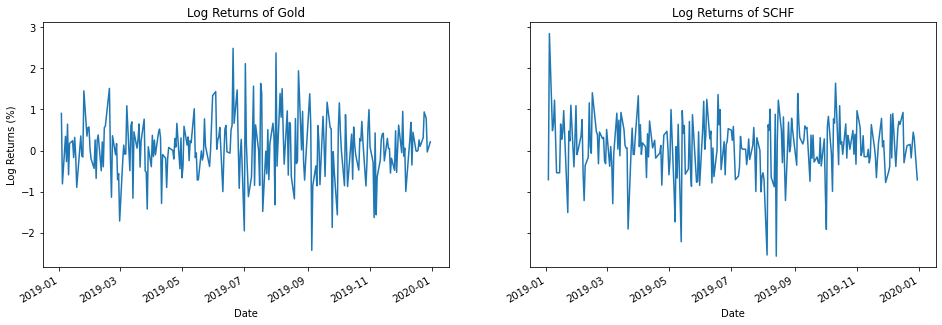

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5), sharey=True)

gld_ret['Log Returns'].plot(ax=axes[0])
eqty_ret['Log Returns'].plot(ax=axes[1])

axes[0].set_title("Log Returns of Gold")
axes[1].set_title("Log Returns of SCHF")

axes[0].set_ylabel('Log Returns (%)')

plt.show()

## Data Summaries

In [5]:
dc = ty['10-2019'].describe()
dc[(dc.index == 'mean') | (dc.index == 'std')]

,24,36,60,84,120,360
mean,1.551364,1.528182,1.52500,1.615000,1.706818,2.190455
std,0.080315,0.096443,0.10446,0.100653,0.104808,0.101300


In [6]:
dc = ty['11-2019'].describe()
dc[(dc.index == 'mean') | (dc.index == 'std')]

,24,36,60,84,120,360
mean,1.612632,1.612105,1.639474,1.735789,1.812105,2.280526
std,0.033804,0.044043,0.052755,0.061039,0.065028,0.076918


In [7]:
dc = gld['10-2019'].describe()
dc[(dc.index == 'mean') | (dc.index == 'std')][['Adj Close']]

,Adj Close
mean,140.874782
std,0.831229


In [8]:
dc = gld['11-2019'].describe()
dc[(dc.index == 'mean') | (dc.index == 'std')][['Adj Close']]

,Adj Close
mean,138.570500
std,1.562095


In [9]:
dc = eqty['10-2019'].describe()
dc[(dc.index == 'mean') | (dc.index == 'std')][['Adj Close']]

,Adj Close
mean,30.438485
std,0.634237


In [10]:
dc = eqty['11-2019'].describe()
dc[(dc.index == 'mean') | (dc.index == 'std')][['Adj Close']]

,Adj Close
mean,31.609971
std,0.110721


## Graphing

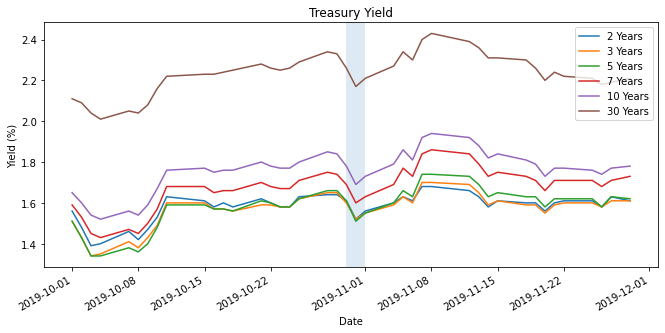

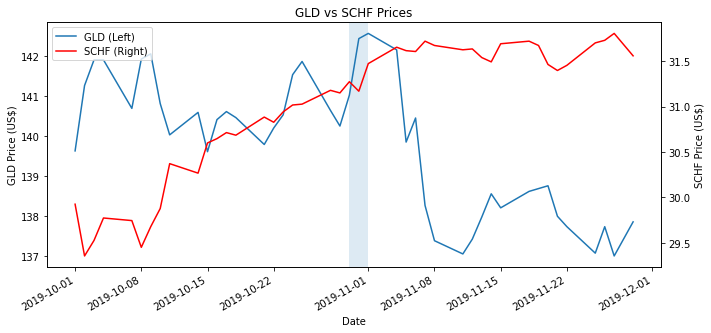

In [11]:
# Treasury Yield
ty['10-2019':'11-2019'].plot(figsize=(11, 5))
plt.axvspan(xmin=datetime(2019, 10, 30), xmax=datetime(2019, 11, 1), alpha=0.15)

plt.ylabel("Yield (%)")
plt.legend(["2 Years", "3 Years", "5 Years", "7 Years", "10 Years", "30 Years"])
plt.title("Treasury Yield")
plt.show()


# GOLD & eqty Price
fig = plt.figure(figsize=(11, 5))
ax  = plt.axes()
gld['10-2019':'11-2019']['Adj Close'].plot(ax=ax, label="GLD (Left)")
ax.set_ylabel("GLD Price (US$)")

ax2 = plt.twinx(ax=ax)
eqty['10-2019':'11-2019']['Adj Close'].plot(ax=ax2, c='r', label="SCHF (Right)")
ax2.set_ylabel("SCHF Price (US$)")

plt.axvspan(xmin=datetime(2019, 10, 30), xmax=datetime(2019, 11, 1), alpha=0.15)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")

plt.title("GLD vs SCHF Prices")
plt.show()

# Fitting Yield Curve With Nelson-Siegel Model

In [12]:
def nsModel(df, ld=0.0609):
    
    # Prepare Regressors
    for i, mth in enumerate(df.columns):

        T     = float(mth) / 12
        reg_1 = (1 - np.exp(-ld * T))  / (ld * T)
        reg_2 = (1 - np.exp(-ld * T))  / (ld * T)  - np.exp(-ld * T)

        if i == 0:
            reg = np.hstack((reg_1, reg_2))

        else:
            reg = np.vstack((reg, np.hstack((reg_1, reg_2))))


    # Regress and compile coefficients
    for i in range(len(df.index)):
        # Prepare Y
        y = df.iloc[i, :].values.copy().reshape(-1, 1)

        # Fit Linear Regression
        lr = LinearRegression()
        lr.fit(X=reg, y=y)

        intercept = lr.intercept_.copy().reshape(-1, 1)
        beta_coef = lr.coef_.copy()

        if i == 0:
            coef = np.hstack((intercept, beta_coef))
        else:
            coef = np.vstack((coef, np.hstack((intercept, beta_coef))))
    
    return reg, coef

###### Plot beta coefficients

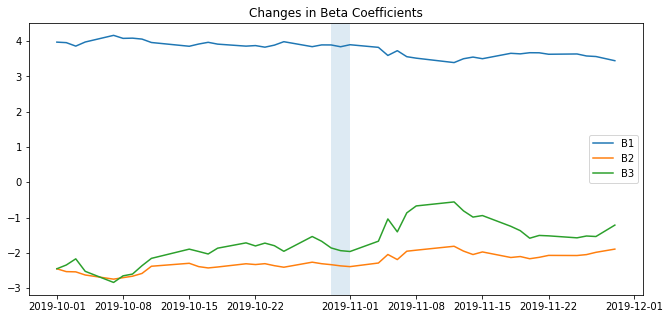

In [13]:
# As per Diebold & Li's interpretation, setting lambda as 0.0609
ld = 0.0609

df        = ty['10-2019':'11-2019'].copy()
reg, coef = nsModel(df=df, ld=ld)

plt.figure(figsize=(11, 5))

plt.axvspan(xmin=datetime(2019, 10, 30), xmax=datetime(2019, 11, 1), alpha=0.15)
plt.plot(df.index, coef[:, 0], label='B1')
plt.plot(df.index, coef[:, 1], label='B2')
plt.plot(df.index, coef[:, 2], label='B3')
plt.title('Changes in Beta Coefficients')
plt.legend()
plt.show()

## Modeling Prices

In [14]:
def best_params(scores):
    
    best_score = 1e5
    best_order = ()
    
    for k, v in scores.items():
        if v < best_score:
            best_score = v
            best_order = k
    
    print(f'The best set of parameters is: {best_order}')
    print(f'Score: {best_score}')
            
    return best_order, best_score

# Function to identify parameters that yields best score
def fit_best_params(endog, p_range, q_range):
    
    scores = {}
    
    # Loop through p and q
    for p in range(p_range[0], p_range[1]):
        
        for q in range(q_range[0], q_range[1]):
            
            # Fit ARIMA model with order of (integration = 0) => ARMA(p, q)
            try:
                order = (p, 0, q)

                mdl = ARIMA(endog, order=order)
                mdl = mdl.fit()

                scores[order] = mdl.aic
            except:
                pass
    
    # Identify best parameters with best scores
    best_order, best_score = best_params(scores)
    
    # Fit best parameters
    mdl = ARIMA(endog, order=best_order)
    mdl = mdl.fit()
    
    return mdl, best_order, best_score

In [15]:
mdl, best_order, best_score = fit_best_params(gld_ret['10-2019'].values, p_range=(1, 6), q_range=(1, 6))
mdl.summary()

c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

The best set of parameters is: (1, 0, 3)
Score: 45.51691286844054


c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                 ARIMA(1, 0, 3)   Log Likelihood                 -16.758
Date:                Sat, 26 Jun 2021   AIC                             45.517
Time:                        21:17:14   BIC                             52.330
Sample:                             0   HQIC                            47.230
                                 - 23                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0289      0.043      0.672      0.501      -0.055       0.113
ar.L1         -0.6011      0.319     -1.883      0.060      -1.227       0.025
ma.L1          0.6651    127.422      0.005      0.996    -249.078     250.408
ma.L2         -0.6654    195.866     -0.003      0.997    -384.556     383.225
ma.L3         -0.9987    117.570     -0.008      0.993    -231.431     229.434
sigma2         0.1911     22.427      0.009      0.993     -43.765      44.147
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.96   Prob(JB):                         0.79
Heteroskedasticity (H):               0.42   Skew:                             0.13
Prob(H) (two-sided):                  0.24   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
mdl, best_order, best_score = fit_best_params(gld_ret['11-2019'].values, p_range=(1, 6), q_range=(1, 6))
mdl.summary()

c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-package

The best set of parameters is: (1, 0, 1)
Score: 41.668484846371136


c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -16.834
Date:                Sat, 26 Jun 2021   AIC                             41.668
Time:                        21:17:20   BIC                             45.651
Sample:                             0   HQIC                            42.446
                                 - 20                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1631      0.172     -0.951      0.342      -0.499       0.173
ar.L1         -1.0000      0.129     -7.734      0.000      -1.253      -0.747
ma.L1          0.9978     16.468      0.061      0.952     -31.280      33.275
sigma2         0.2875      4.659      0.062      0.951      -8.844       9.419
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 5.35
Prob(Q):                              0.78   Prob(JB):                         0.07
Heteroskedasticity (H):               0.14   Skew:                            -1.18
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
mdl, best_order, best_score = fit_best_params(eqty_ret['10-2019'].values, p_range=(1, 6), q_range=(1, 6))
mdl.summary()

c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting paramete

The best set of parameters is: (5, 0, 1)
Score: 56.457781680767496


c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                 ARIMA(5, 0, 1)   Log Likelihood                 -20.229
Date:                Sat, 26 Jun 2021   AIC                             56.458
Time:                        21:17:28   BIC                             65.542
Sample:                             0   HQIC                            58.742
                                 - 23                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2351      0.062      3.812      0.000       0.114       0.356
ar.L1          0.9115      0.399      2.285      0.022       0.130       1.693
ar.L2         -0.2760      0.321     -0.859      0.390      -0.906       0.354
ar.L3         -0.1542      0.263     -0.587      0.557      -0.669       0.360
ar.L4          0.6894      0.286      2.411      0.016       0.129       1.250
ar.L5         -0.6499      0.170     -3.821      0.000      -0.983      -0.317
ma.L1         -0.9847      2.649     -0.372      0.710      -6.177       4.208
sigma2         0.2749      0.669      0.411      0.681      -1.037       1.587
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.68   Prob(JB):                         0.83
Heteroskedasticity (H):               0.37   Skew:                            -0.29
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
mdl, best_order, best_score = fit_best_params(eqty_ret['11-2019'].values, p_range=(1, 6), q_range=(1, 6))
mdl.summary()

c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

The best set of parameters is: (1, 0, 3)
Score: 26.713971520006446


c:\users\elroy\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                 ARIMA(1, 0, 3)   Log Likelihood                  -7.357
Date:                Sat, 26 Jun 2021   AIC                             26.714
Time:                        21:17:36   BIC                             32.688
Sample:                             0   HQIC                            27.880
                                 - 20                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0256      0.042      0.613      0.540      -0.056       0.107
ar.L1         -0.5681      0.493     -1.153      0.249      -1.534       0.398
ma.L1          0.6969   8519.527   8.18e-05      1.000   -1.67e+04    1.67e+04
ma.L2         -0.6996   1.44e+04  -4.84e-05      1.000   -2.83e+04    2.83e+04
ma.L3         -0.9973   8485.598     -0.000      1.000   -1.66e+04    1.66e+04
sigma2         0.0910    773.967      0.000      1.000   -1516.857    1517.039
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.05
Prob(Q):                              0.70   Prob(JB):                         0.59
Heteroskedasticity (H):               1.05   Skew:                            -0.55
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

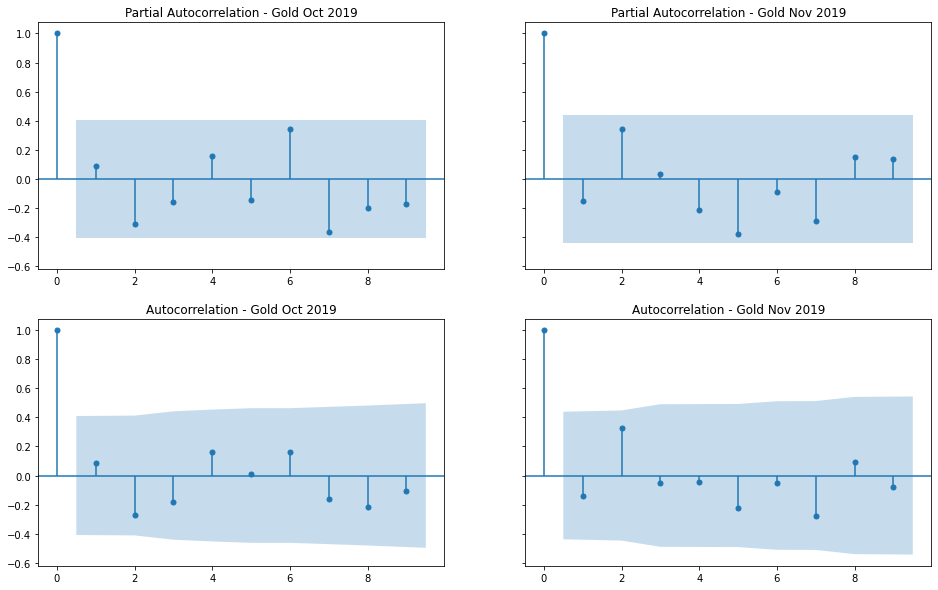

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10), sharey=True)

plot_pacf(gld_ret['10-2019'].values, lags=9, ax=axes[0][0], title='Partial Autocorrelation - Gold Oct 2019')
plot_acf(gld_ret['10-2019'].values, lags=9, ax=axes[1][0], title='Autocorrelation - Gold Oct 2019')

plot_pacf(gld_ret['11-2019'].values, lags=9, ax=axes[0][1], title='Partial Autocorrelation - Gold Nov 2019')
plot_acf(gld_ret['11-2019'].values, lags=9, ax=axes[1][1], title='Autocorrelation - Gold Nov 2019')

plt.show()

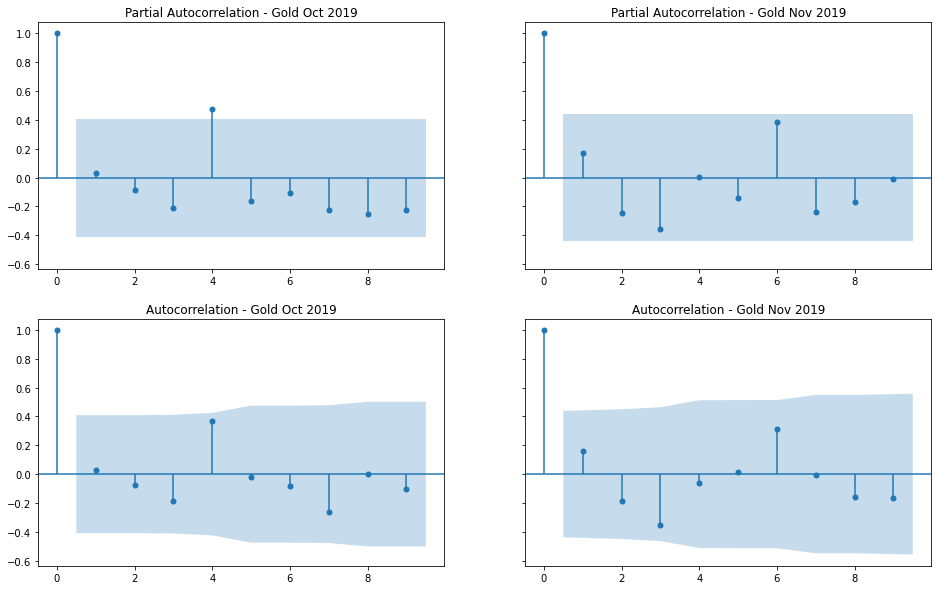

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10), sharey=True)

plot_pacf(eqty_ret['10-2019'].values, lags=9, ax=axes[0][0], title='Partial Autocorrelation - Gold Oct 2019')
plot_acf(eqty_ret['10-2019'].values, lags=9, ax=axes[1][0], title='Autocorrelation - Gold Oct 2019')

plot_pacf(eqty_ret['11-2019'].values, lags=9, ax=axes[0][1], title='Partial Autocorrelation - Gold Nov 2019')
plot_acf(eqty_ret['11-2019'].values, lags=9, ax=axes[1][1], title='Autocorrelation - Gold Nov 2019')

plt.show()

## Modeling Volatility

#### Gold

In [21]:
# Gold October high-low mean
(gld['10-2019']['High'] - gld['10-2019']['Low']).describe().to_frame().T[['mean']]

,mean
0,1.081305


In [22]:
# Gold Nov high-low mean
(gld['11-2019']['High'] - gld['11-2019']['Low']).describe().to_frame().T[['mean']]

,mean
0,0.972498


In [23]:
# Gold Returns Oct Std
gld_ret['10-2019'].describe().T[['mean', 'std']]

,mean,std
Log Returns,0.110054,0.610272


In [24]:
# Gold Returns Nov Std
gld_ret['11-2019'].describe().T[['mean', 'std']]

,mean,std
Log Returns,-0.16306,0.621744


In [25]:
mdl = arch_model((gld_ret['10-2019']['Log Returns']), vol='garch', p=1, o=0, q=1)
mdl = mdl.fit()
mdl.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13368341.661700156
Iteration:      2,   Func. Count:     13,   Neg. LLF: 21.05972916561349
Iteration:      3,   Func. Count:     19,   Neg. LLF: 21.01493685043708
Iteration:      4,   Func. Count:     25,   Neg. LLF: 20.94133539051417
Iteration:      5,   Func. Count:     31,   Neg. LLF: 20.890043697788983
Iteration:      6,   Func. Count:     37,   Neg. LLF: 20.845804134008684
Iteration:      7,   Func. Count:     43,   Neg. LLF: 20.73795653316183
Iteration:      8,   Func. Count:     49,   Neg. LLF: 21.43263808176639
Iteration:      9,   Func. Count:     55,   Neg. LLF: 20.71459130328676
Iteration:     10,   Func. Count:     61,   Neg. LLF: 20.71899022489979
Iteration:     11,   Func. Count:     67,   Neg. LLF: 20.699353890311137
Iteration:     12,   Func. Count:     72,   Neg. LLF: 20.698347838313484
Iteration:     13,   Func. Count:     77,   Neg. LLF: 20.697889706547134
Iteration:     14,   Func. Count:     82,   Neg. LLF: 20.6

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -20.6961
Distribution:                  Normal   AIC:                           49.3922
Method:            Maximum Likelihood   BIC:                           53.9342
                                        No. Observations:                   23
Date:                Sat, Jun 26 2021   Df Residuals:                       22
Time:                        21:17:37   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1071      0.119      0.903      0.367 [ -0.125,  0.340]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0209  6.529e-02      0.320      0.749      [ -0.107,  0.149]
alpha[1]   6.1917e-14  4.338e-02  1.427e-12      1.000 [-8.503e-02,8.503e-02]
beta[1]        0.9300      0.228      4.085  4.412e-05      [  0.484,  1.376]
=============================================================================

Covariance estimator: robust
"""

In [26]:
mdl = arch_model((gld_ret['11-2019']['Log Returns']), vol='garch', p=1, o=0, q=1)
mdl = mdl.fit()
mdl.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 20670595.880612142
Iteration:      2,   Func. Count:     13,   Neg. LLF: 31.76021103680337
Iteration:      3,   Func. Count:     20,   Neg. LLF: 19.477391194550435
Iteration:      4,   Func. Count:     26,   Neg. LLF: 19.156673939709457
Iteration:      5,   Func. Count:     32,   Neg. LLF: 19.149831511377506
Iteration:      6,   Func. Count:     38,   Neg. LLF: 19.175899079048378
Iteration:      7,   Func. Count:     44,   Neg. LLF: 19.176999707307996
Iteration:      8,   Func. Count:     50,   Neg. LLF: 19.14596193840041
Iteration:      9,   Func. Count:     56,   Neg. LLF: 18.605227912077794
Iteration:     10,   Func. Count:     62,   Neg. LLF: 18.01511876619679
Iteration:     11,   Func. Count:     67,   Neg. LLF: 18.00306967725509
Iteration:     12,   Func. Count:     73,   Neg. LLF: 37.69943162717174
Iteration:     13,   Func. Count:     81,   Neg. LLF: 17.887354856876133
Iteration:     14,   Func. Count:     87,   Neg. LLF: 20

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -17.6632
Distribution:                  Normal   AIC:                           43.3264
Method:            Maximum Likelihood   BIC:                           47.3093
                                        No. Observations:                   20
Date:                Sat, Jun 26 2021   Df Residuals:                       19
Time:                        21:17:37   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.1251      0.132     -0.948      0.343 [ -0.384,  0.134]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.3928e-03  3.455e-02  6.926e-02      0.945 [-6.532e-02,7.011e-02]
alpha[1]   3.3740e-15  4.791e-02  7.043e-14      1.000 [-9.390e-02,9.390e-02]
beta[1]        0.9547      0.161      5.914  3.337e-09      [  0.638,  1.271]
=============================================================================

Covariance estimator: robust
"""

#### eqty

In [27]:
# Eqty October high-low mean
(eqty['10-2019']['High'] - eqty['10-2019']['Low']).describe().to_frame().T[['mean']]

,mean
0,0.198261


In [28]:
# Eqty Nov high-low mean
(eqty['11-2019']['High'] - eqty['11-2019']['Low']).describe().to_frame().T[['mean']]

,mean
0,0.139501


In [29]:
# Eqty Returns Oct Std
eqty_ret['10-2019'].describe().T[['mean', 'std']]

,mean,std
Log Returns,0.134369,0.754505


In [30]:
# Eqty Returns Nov Std
eqty_ret['11-2019'].describe().T[['mean', 'std']]

,mean,std
Log Returns,0.061999,0.44218


In [31]:
mdl = arch_model((eqty_ret['10-2019']['Log Returns']), vol='garch', p=1, o=0, q=1)
mdl = mdl.fit()
mdl.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 134086599.71443503
Iteration:      2,   Func. Count:     13,   Neg. LLF: 27093861.94921562
Iteration:      3,   Func. Count:     19,   Neg. LLF: 25.974386700480803
Iteration:      4,   Func. Count:     27,   Neg. LLF: 29.652182986996298
Iteration:      5,   Func. Count:     33,   Neg. LLF: 22.188420632067334
Iteration:      6,   Func. Count:     39,   Neg. LLF: 21.917660782083484
Iteration:      7,   Func. Count:     45,   Neg. LLF: 21.736124982969123
Iteration:      8,   Func. Count:     50,   Neg. LLF: 21.72313629515109
Iteration:      9,   Func. Count:     55,   Neg. LLF: 21.722244864123038
Iteration:     10,   Func. Count:     60,   Neg. LLF: 21.721835403062393
Iteration:     11,   Func. Count:     65,   Neg. LLF: 21.721792273929605
Iteration:     12,   Func. Count:     70,   Neg. LLF: 21.721773834330865
Iteration:     13,   Func. Count:     74,   Neg. LLF: 21.721773834257856
Optimization terminated successfully    (Exit mode 0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -21.7218
Distribution:                  Normal   AIC:                           51.4435
Method:            Maximum Likelihood   BIC:                           55.9855
                                        No. Observations:                   23
Date:                Sat, Jun 26 2021   Df Residuals:                       22
Time:                        21:17:37   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1690  6.689e-02      2.527  1.151e-02 [3.792e-02,  0.300]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0157  1.473e-02      1.063      0.288 [-1.322e-02,4.454e-02]
alpha[1]       0.3669      0.699      0.525      0.599      [ -1.002,  1.736]
beta[1]        0.5690      0.374      1.520      0.128      [ -0.165,  1.303]
=============================================================================

Covariance estimator: robust
"""

In [32]:
mdl = arch_model((eqty_ret['11-2019']['Log Returns']), vol='garch', p=1, o=0, q=1)
mdl = mdl.fit()
mdl.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11904524.118657045
Iteration:      2,   Func. Count:     13,   Neg. LLF: 744.8583593779987
Iteration:      3,   Func. Count:     20,   Neg. LLF: 24.020573028723142
Iteration:      4,   Func. Count:     26,   Neg. LLF: 11.61252020845247
Iteration:      5,   Func. Count:     32,   Neg. LLF: 11.479643380133606
Iteration:      6,   Func. Count:     37,   Neg. LLF: 11.475390116943723
Iteration:      7,   Func. Count:     42,   Neg. LLF: 11.475210990608137
Iteration:      8,   Func. Count:     47,   Neg. LLF: 11.475038670982165
Iteration:      9,   Func. Count:     52,   Neg. LLF: 11.475037391122079
Iteration:     10,   Func. Count:     56,   Neg. LLF: 11.475037391152426
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.475037391122079
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11.4750
Distribution:                  Normal   AIC:                           30.9501
Method:            Maximum Likelihood   BIC:                           34.9330
                                        No. Observations:                   20
Date:                Sat, Jun 26 2021   Df Residuals:                       19
Time:                        21:17:37   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0569  9.994e-02      0.570      0.569 [ -0.139,  0.253]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.0567  9.954e-02      0.570      0.569 [ -0.138,  0.252]
alpha[1]   1.4589e-15      0.196  7.460e-15      1.000 [ -0.383,  0.383]
beta[1]        0.6546      0.774      0.846      0.398 [ -0.863,  2.172]
========================================================================

Covariance estimator: robust
"""

## Correlation

In [33]:
# ETF Correlation Oct 2019
np.corrcoef(gld_ret['10-2019'].values.reshape(-1,), eqty_ret['10-2019'].values.reshape(-1,))

array([[ 1.        , -0.63453505],
       [-0.63453505,  1.        ]])

In [34]:
# ETF Correlation Nov 2019
np.corrcoef(gld_ret['11-2019'].values.reshape(-1,), eqty_ret['11-2019'].values.reshape(-1,))

array([[ 1.        , -0.25445371],
       [-0.25445371,  1.        ]])